# Step 1: Install required libraries

In [1]:
!pip install streamlit
!pip install --upgrade nltk
!pip install contractions
!pip install wordcloud
!pip install emoji

# Step 2: Import necessary libraries for data processing

In [2]:
# Step 2: Import necessary libraries for data processing
import re
import emoji
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 3: Load the CSV dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_sentiment.csv', header=None, index_col=0)
df = df[[2,3]].reset_index(drop=True)  # Select and rename columns
df.columns = ['sentiment', 'text']

# Step 4: Data Cleaning and Preprocessing

In [5]:

# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [6]:
# Convert text to lowercase
df['text'] = df['text'].str.lower()

In [7]:
# Remove URLs, Mentions, Hashtags, Special Characters, Numbers
df['text'] = df['text'].replace(r'http\S+|www\S+|https\S+', '', regex=True)  # Remove URLs
df['text'] = df['text'].replace(r'@\w+|#\w+', '', regex=True)                # Remove Mentions and Hashtags
df['text'] = df['text'].replace(r'[^A-Za-z0-9\s]', '', regex=True)            # Remove Special Characters
df['text'] = df['text'].replace(r'\d+', '', regex=True)                       # Remove Numbers


In [8]:
# Expand contractions
df['text'] = df['text'].apply(contractions.fix)

In [9]:

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [10]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [11]:
# Handle emojis
df['text'] = df['text'].apply(lambda x: emoji.demojize(x))

# Remove repeated characters (e.g., "soooo" -> "soo")
df['text'] = df['text'].apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))


In [12]:
from nltk.tokenize import RegexpTokenizer

In [13]:
# Tokenization Step: Tokenize the text using RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')  # Tokenizer to extract words
df['text'] = df['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))  # Tokenize and join back as space-separated



# Step 5: Add tweet length column and remove tweets with zero length

In [14]:
df['tweet_length'] = df['text'].apply(len)
df = df[df['tweet_length'] > 0]

# Step 6: Exploratory Data Analysis (EDA)

In [15]:
# Function to display word frequency
def word_frequency(df, text_column, num_words=20):
    all_words = ' '.join(df[text_column]).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(num_words)

In [16]:
# Function to plot word cloud
def plot_wordcloud(df, text_column):
    all_words = ' '.join(df[text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [17]:
# Function to plot tweet length distribution
def plot_tweet_lengths(df):
    plt.figure(figsize=(8, 6))
    sns.histplot(df['tweet_length'], bins=20, kde=True)
    plt.title('Distribution of Tweet Lengths')
    plt.show()

In [18]:
# Function to plot sentiment distribution
def plot_sentiment_distribution(df, sentiment_column):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=sentiment_column, data=df)
    plt.title('Sentiment Distribution')
    plt.show()


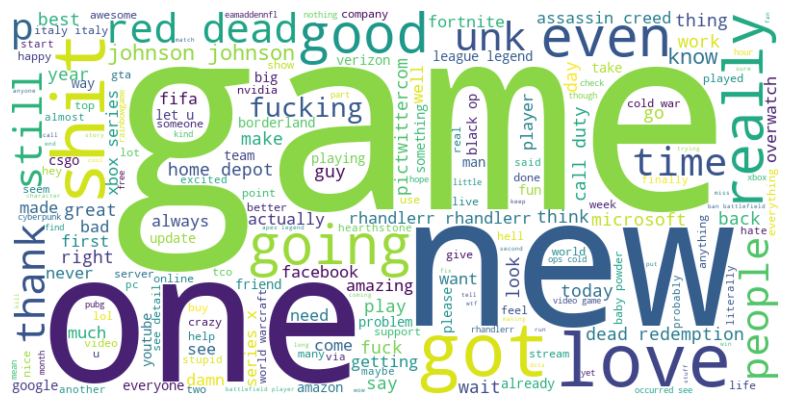

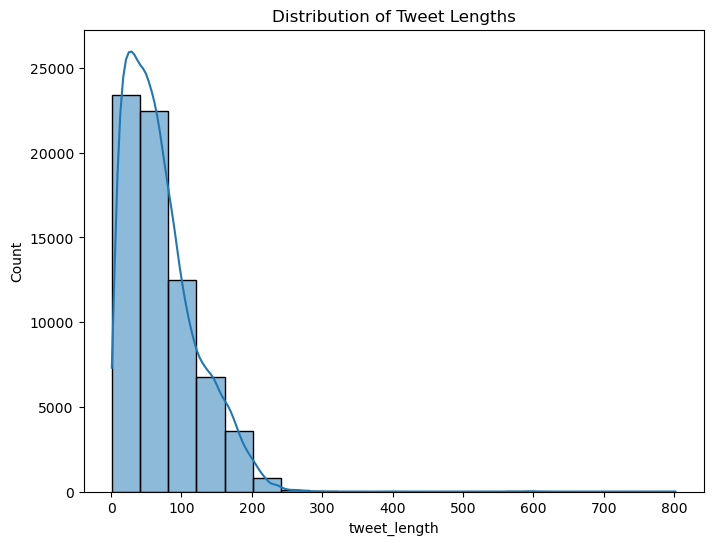

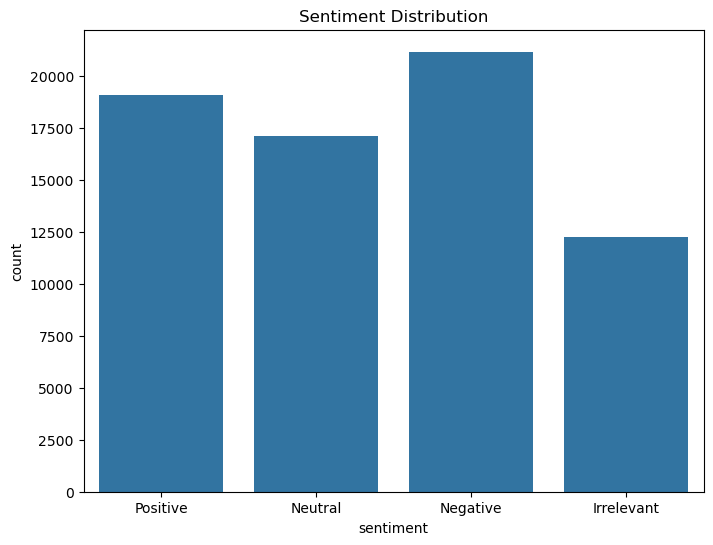

In [19]:
# Visualize the EDA results
plot_wordcloud(df, 'text')
plot_tweet_lengths(df)
plot_sentiment_distribution(df, 'sentiment')


# Step 7: Split data into training and testing sets

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)


# Step 8: Build a Random Forest model pipeline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
# Random Forest with hyperparameter tuning
clf = Pipeline([
    ('tfid', TfidfVectorizer()),  # Convert text to TF-IDF vectors
    ('rfc', RandomForestClassifier(random_state=42))
])


In [23]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'rfc__n_estimators': [50, 100, 200],
    'rfc__max_depth': [10, 20, None],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__bootstrap': [True, False]
}

In [24]:
# Set up the GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)


In [25]:
# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)


Fitting 2 folds for each of 162 candidates, totalling 324 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rfc__bootstrap': [True, False],
                         'rfc__max_depth': [10, 20, None],
                         'rfc__min_samples_leaf': [1, 2, 4],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [26]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best parameters found:  {'rfc__bootstrap': False, 'rfc__max_depth': None, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}
Best accuracy:  0.8445425344218691


# Step 9: Evaluate the model

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the test set results using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  Irrelevant       0.96      0.87      0.91      2566
    Negative       0.90      0.95      0.93      4153
     Neutral       0.94      0.91      0.93      3408
    Positive       0.91      0.94      0.92      3802

    accuracy                           0.92     13929
   macro avg       0.93      0.92      0.92     13929
weighted avg       0.93      0.92      0.92     13929



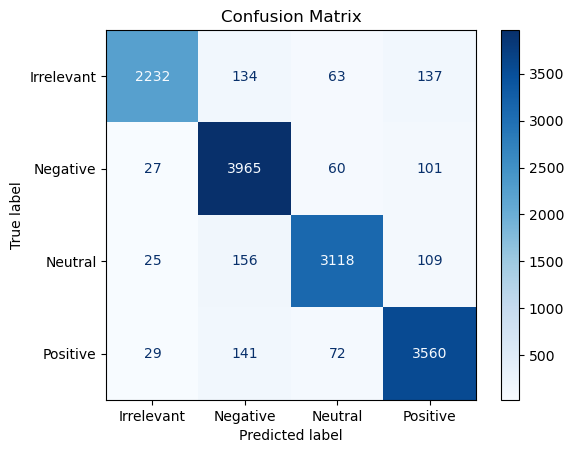

In [28]:
# Display confusion matrix
# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()


# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Step 10: Save the model

In [29]:
# Save the model
import pickle
pickle.dump(grid_search.best_estimator_, open('twitter_sentiment_best.pkl', 'wb'))

# Step 11: Make predictions on new tweets


In [30]:
rf = grid_search.best_estimator_

In [31]:
print(rf.predict(['let me not upset you']))
print(rf.predict(['glad to see you']))
print(rf.predict(['how the hell are we into halloween month already']))
print(rf.predict(['i have done nothing but playing football']))

['Negative']
['Positive']
['Irrelevant']
['Negative']
